In [21]:
from pandas.tseries.offsets import BDay
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import alphalens
import csv

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [20]:
# First, read the result and config file of a backtested strategy.
result_csv = '/Users/Brad Sun/Dropbox/ACCERN/json_backtest_record/results/3_21_vipul_multi_data_3_initialize_algorithms_table_results.csv'
config_csv = '/Users/Brad Sun/Dropbox/ACCERN/json_backtest_record/configs/3_21_vipul_multi_data_3_close_to_close_sp500_config.csv'

# This is the name of the pic that's gonna be saved at the end of this notebook
save_pic_name = '3_21_vipul_multi_data_3_sp500_ctc_daily_results'

In [22]:
# Let's first see what result and config files look like:
result = pd.read_csv(result_csv)
config = pd.read_csv(config_csv)

In [25]:
result.head(3)

,algo_id,title,backtest_id,alpha,beta,sharpe,sortino,total_returns,benchmark_returns,volatility,max_drawdown,backtest_url
0,5ab2ad341274a90a283a605c,3_21_vipul_multi_data_3_ctc_100mil_23,5ab2ad471311344338806fc9,0.06,-0.08,1.53,2.31,23%,71.10%,0.03,-3%,https://www.quantopian.com/algorithms/5ab2ad34...
1,5ab2a8181274a96da63a608b,3_21_vipul_multi_data_3_ctc_1mil_21,5ab2a8260ddace414b0dcb9e,0.07,1.08,1.50,2.16,135.18%,71.10%,0.14,-15.90%,https://www.quantopian.com/algorithms/5ab2a818...
2,5ab2a3e01274a900153a6262,3_21_vipul_multi_data_3_ctc_1mil_2,5ab2a3f21311344338806e11,0.11,0.53,2.04,3.15,114.35%,71.10%,0.09,-6%,https://www.quantopian.com/algorithms/5ab2a3e0...


In [26]:
config.head(3)

,algo_name,algo_file,data_file,start_date,end_date,capital,num_stocks_to_trade,long_half,short_half
0,3_21_vipul_multi_data_3_ctc_1mil_1,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,10,1.00,0.00
1,3_21_vipul_multi_data_3_ctc_1mil_2,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,10,0.75,0.25
2,3_21_vipul_multi_data_3_ctc_1mil_3,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,10,0.50,0.50


# Preprocessing Mode

In [27]:
# Change the result file columns so that it can be merged with config file, 'algo_name' is the column to merge on
result.columns = ['algo_id', 'algo_name', 'backtest_id', 'alpha', 'beta', 'sharpe', 'sortino',
       'total_returns', 'benchmark_returns', 'volatility', 'max_drawdown',
       'backtest_url']

In [28]:
merged = result.merge(config, on = 'algo_name')

In [29]:
merged.head(2)

,algo_id,algo_name,backtest_id,alpha,beta,sharpe,sortino,total_returns,benchmark_returns,volatility,max_drawdown,backtest_url,algo_file,data_file,start_date,end_date,capital,num_stocks_to_trade,long_half,short_half
0,5ab2ad341274a90a283a605c,3_21_vipul_multi_data_3_ctc_100mil_23,5ab2ad471311344338806fc9,0.06,-0.08,1.53,2.31,23%,71.10%,0.03,-3%,https://www.quantopian.com/algorithms/5ab2ad34...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,50,0.5,0.5
1,5ab2a8181274a96da63a608b,3_21_vipul_multi_data_3_ctc_1mil_21,5ab2a8260ddace414b0dcb9e,0.07,1.08,1.50,2.16,135.18%,71.10%,0.14,-15.90%,https://www.quantopian.com/algorithms/5ab2a818...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,50,1.0,0.0


In [30]:
# Preprocess the types of the elements inside the dataframe to make them calculatable for later use.
title_to_convert_to_float = ['alpha', 'beta', 'sharpe', 'sortino', 'volatility']
title_to_strip_pct = ['total_returns', 'benchmark_returns', 'max_drawdown']

for col in title_to_convert_to_float:
    merged[col] = merged[col].apply(lambda x: float(x))
for col in title_to_strip_pct:
    merged[col] = merged[col].apply(lambda x: x.strip('%'))
    merged[col] = merged[col].apply(lambda x: float(x))
    merged[col] = merged[col]/100

In [31]:
# Add one more performance metric: annualized return: 4.25 is the number of years backtested
merged['annualized_returns'] = (1+merged['total_returns'])**(1/4.25) - 1

In [32]:
merged.head()

,algo_id,algo_name,backtest_id,alpha,beta,sharpe,sortino,total_returns,benchmark_returns,volatility,...,backtest_url,algo_file,data_file,start_date,end_date,capital,num_stocks_to_trade,long_half,short_half,annualized_returns
0,5ab2ad341274a90a283a605c,3_21_vipul_multi_data_3_ctc_100mil_23,5ab2ad471311344338806fc9,0.06,-0.08,1.53,2.31,0.2300,0.711,0.03,...,https://www.quantopian.com/algorithms/5ab2ad34...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,50,0.50,0.50,0.049915
1,5ab2a8181274a96da63a608b,3_21_vipul_multi_data_3_ctc_1mil_21,5ab2a8260ddace414b0dcb9e,0.07,1.08,1.50,2.16,1.3518,0.711,0.14,...,https://www.quantopian.com/algorithms/5ab2a818...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,50,1.00,0.00,0.222893
2,5ab2a3e01274a900153a6262,3_21_vipul_multi_data_3_ctc_1mil_2,5ab2a3f21311344338806e11,0.11,0.53,2.04,3.15,1.1435,0.711,0.09,...,https://www.quantopian.com/algorithms/5ab2a3e0...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,10,0.75,0.25,0.196496
3,5ab2ad041274a9000f3a62f0,3_21_vipul_multi_data_3_ctc_100mil_22,5ab2ad16fe98ee41037abd7a,0.06,0.38,2.00,3.02,0.5994,0.711,0.05,...,https://www.quantopian.com/algorithms/5ab2ad04...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,50,0.75,0.25,0.116837
4,5ab2a9f4ce20ea07dbd504e1,3_21_vipul_multi_data_3_ctc_100mil_7,5ab2aa0673168242ea8c84db,0.07,0.34,1.99,3.01,0.6118,0.711,0.06,...,https://www.quantopian.com/algorithms/5ab2a9f4...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,20,0.75,0.25,0.118869


# Research Mode:

In [33]:
research = merged.copy()

# Construct a heatmap analysis graph for all strats:
df = pd.DataFrame(index = research.index)
df['sharpe'] = research.sharpe
df['long_exposure'] = research.long_half
df['num_stocks'] = research.num_stocks_to_trade
df['capital_capacity'] = research.capital
df['alpha'] = research.alpha
df['beta'] = research.beta
df['total_returns'] = research.total_returns
df['volatility'] = research.volatility
df['max_drawdown'] = research.max_drawdown
df['annualized_returns'] = research.annualized_returns
df_reset_index = df.reset_index()

In [35]:
research.head(10)

,algo_id,algo_name,backtest_id,alpha,beta,sharpe,sortino,total_returns,benchmark_returns,volatility,...,backtest_url,algo_file,data_file,start_date,end_date,capital,num_stocks_to_trade,long_half,short_half,annualized_returns
0,5ab2ad341274a90a283a605c,3_21_vipul_multi_data_3_ctc_100mil_23,5ab2ad471311344338806fc9,0.06,-0.08,1.53,2.31,0.2300,0.711,0.03,...,https://www.quantopian.com/algorithms/5ab2ad34...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,50,0.50,0.50,0.049915
1,5ab2a8181274a96da63a608b,3_21_vipul_multi_data_3_ctc_1mil_21,5ab2a8260ddace414b0dcb9e,0.07,1.08,1.50,2.16,1.3518,0.711,0.14,...,https://www.quantopian.com/algorithms/5ab2a818...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,50,1.00,0.00,0.222893
2,5ab2a3e01274a900153a6262,3_21_vipul_multi_data_3_ctc_1mil_2,5ab2a3f21311344338806e11,0.11,0.53,2.04,3.15,1.1435,0.711,0.09,...,https://www.quantopian.com/algorithms/5ab2a3e0...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,10,0.75,0.25,0.196496
3,5ab2ad041274a9000f3a62f0,3_21_vipul_multi_data_3_ctc_100mil_22,5ab2ad16fe98ee41037abd7a,0.06,0.38,2.00,3.02,0.5994,0.711,0.05,...,https://www.quantopian.com/algorithms/5ab2ad04...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,50,0.75,0.25,0.116837
4,5ab2a9f4ce20ea07dbd504e1,3_21_vipul_multi_data_3_ctc_100mil_7,5ab2aa0673168242ea8c84db,0.07,0.34,1.99,3.01,0.6118,0.711,0.06,...,https://www.quantopian.com/algorithms/5ab2a9f4...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,20,0.75,0.25,0.118869
5,5ab2a4e9e89f310012dd44ec,3_21_vipul_multi_data_3_ctc_1mil_7,5ab2a4f6934aec4234008b03,0.08,0.53,1.97,2.92,0.9251,0.711,0.08,...,https://www.quantopian.com/algorithms/5ab2a4e9...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,20,0.75,0.25,0.166622
6,5ab2a3b6e89f3157a6dd435b,3_21_vipul_multi_data_3_ctc_1mil_1,5ab2a3c9c60f8042dc00ee00,0.14,1.08,1.87,2.79,2.1871,0.711,0.15,...,https://www.quantopian.com/algorithms/5ab2a3b6...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,10,1.00,0.00,0.313548
7,5ab2a8371274a979db3a6038,3_21_vipul_multi_data_3_ctc_1mil_22,5ab2a8441f002840cf20b8f8,0.06,0.49,1.83,2.72,0.6946,0.711,0.07,...,https://www.quantopian.com/algorithms/5ab2a837...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,50,0.75,0.25,0.132135
8,5ab2a5631274a96da63a6055,3_21_vipul_multi_data_3_ctc_1mil_8,5ab2a5751f002840cf20b82f,0.08,0.00,1.82,2.87,0.3858,0.711,0.04,...,https://www.quantopian.com/algorithms/5ab2a563...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,20,0.50,0.50,0.079795
9,5ab2ac35e89f31180add454e,3_21_vipul_multi_data_3_ctc_100mil_17,5ab2ac48934aec4234008ba3,0.05,0.40,1.72,2.52,0.5210,0.711,0.06,...,https://www.quantopian.com/algorithms/5ab2ac35...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,40,0.75,0.25,0.103707


In [36]:
# Look for the strategy rows with 1 mil AUM
df_1_mil = df_reset_index[df_reset_index.capital_capacity == 1000000]
# Look for the stratgey rows with 100 mil AUM
df_100_mil = df_reset_index[df_reset_index.capital_capacity == 100000000]

sharpe_1_mil = pd.pivot_table(df_1_mil, index = 'num_stocks', columns=['long_exposure'], values='sharpe')
alpha_1_mil = pd.pivot_table(df_1_mil, index = 'num_stocks', columns=['long_exposure'], values='alpha')
beta_1_mil = pd.pivot_table(df_1_mil, index = 'num_stocks', columns=['long_exposure'], values='beta')
vol_1_mil = pd.pivot_table(df_1_mil, index = 'num_stocks', columns=['long_exposure'], values='volatility')
total_r_1_mil = pd.pivot_table(df_1_mil, index = 'num_stocks', columns=['long_exposure'], values='total_returns')
annualized_1_mil = pd.pivot_table(df_1_mil, index = 'num_stocks', columns=['long_exposure'], values='annualized_returns')

sharpe_100_mil = pd.pivot_table(df_100_mil, index = 'num_stocks', columns=['long_exposure'], values='sharpe')
alpha_100_mil = pd.pivot_table(df_100_mil, index = 'num_stocks', columns=['long_exposure'], values='alpha')
beta_100_mil = pd.pivot_table(df_100_mil, index = 'num_stocks', columns=['long_exposure'], values='beta')
vol_100_mil = pd.pivot_table(df_100_mil, index = 'num_stocks', columns=['long_exposure'], values='volatility')
total_r_100_mil = pd.pivot_table(df_100_mil, index = 'num_stocks', columns=['long_exposure'], values='total_returns')
annualized_100_mil = pd.pivot_table(df_100_mil, index = 'num_stocks', columns=['long_exposure'], values='annualized_returns')

In [37]:
# Show an example of the processed dataframe of a specific performance metric
sharpe_1_mil.head()

long_exposure,0.0,0.25,0.5,0.75,1.0
num_stocks,,,,,
10,-0.66,-0.10,1.52,2.04,1.87
20,-0.56,-0.03,1.82,1.97,1.69
30,-0.70,-0.42,1.22,1.63,1.58
40,-0.73,-0.38,1.28,1.59,1.45
50,-0.76,-0.24,1.60,1.83,1.50


In [38]:
# Prepare different types of heatmaps just in case we need different types:
def get_heatmap(df, metric_str, cap, color_1, color_2, vmax, vmin):
    fig, ax = plt.subplots(figsize=(10,8))         # Sample figsize in inches
    cmap = sns.diverging_palette(color_1, color_2, sep=20, as_cmap=True)
    sns.heatmap(df, cmap = cmap, ax=ax, vmax=vmax, vmin=vmin, annot=True,linewidths=.5)
    plt.title('{} (${}million)'.format(metric_str, cap), fontsize = 14)
    ax.invert_yaxis()
    fig.savefig('{}_{}_{}_mil.png'.format(save_pic_name, metric_str, cap))
    
def get_heatmap_plain(df, metric_str, cap, vmax, vmin):
    fig, ax = plt.subplots(figsize=(10,8))         # Sample figsize in inches
#     cmap = sns.diverging_palette(color_1, color_2, sep=20, as_cmap=True)
    sns.heatmap(df, cmap = 'Blues', ax=ax, vmax=vmax, vmin=vmin, annot=True,linewidths=.5)
    plt.title('{} (${}million)'.format(metric_str, cap), fontsize = 14)
    ax.invert_yaxis()
    fig.savefig('{}_{}_{}_mil.png'.format(save_pic_name, metric_str, cap))
    
def get_heatmap_plain_no_min_max(df, metric_str, cap):
    fig, ax = plt.subplots(figsize=(10,8))         # Sample figsize in inches
#     cmap = sns.diverging_palette(color_1, color_2, sep=20, as_cmap=True)
    sns.heatmap(df, cmap = 'Blues', ax=ax, annot=True,linewidths=.5)
    plt.title('{} (${}million)'.format(metric_str, cap), fontsize = 14)
    ax.invert_yaxis()
    fig.savefig('{}_{}_{}_mil.png'.format(save_pic_name, metric_str, cap))
    
def get_heatmap_plain_no_min_max_vol(df, metric_str, cap):
    fig, ax = plt.subplots(figsize=(10,8))         # Sample figsize in inches
#     cmap = sns.diverging_palette(color_1, color_2, sep=20, as_cmap=True)
    sns.heatmap(df, cmap = 'Greys', ax=ax, annot=True,linewidths=.5)
    plt.title('{} (${}million)'.format(metric_str, cap), fontsize = 14)
    ax.invert_yaxis()
    fig.savefig('{}_{}_{}_mil.png'.format(save_pic_name, metric_str, cap))
    
def get_heatmap_plain_grey(df, metric_str, cap, vmax, vmin):
    fig, ax = plt.subplots(figsize=(10,8))         # Sample figsize in inches
#     cmap = sns.diverging_palette(color_1, color_2, sep=20, as_cmap=True)
    sns.heatmap(df, cmap = 'Greys', ax=ax, vmax=vmax, vmin=vmin, annot=True,linewidths=.5)
    plt.title('{} (${}million)'.format(metric_str, cap), fontsize = 14)
    ax.invert_yaxis()
    fig.savefig('{}_{}_{}_mil.png'.format(save_pic_name, metric_str, cap))

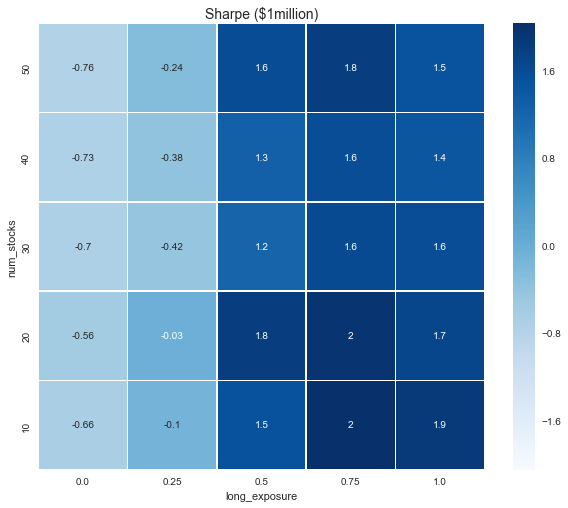

In [39]:
get_heatmap_plain_no_min_max(sharpe_1_mil, 'Sharpe', '1')

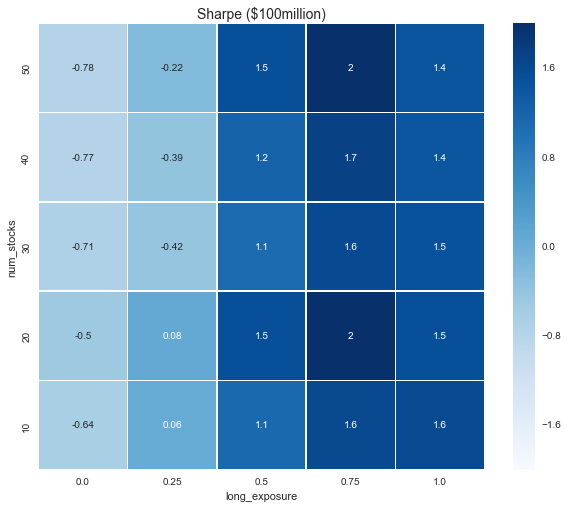

In [40]:
get_heatmap_plain_no_min_max(sharpe_100_mil, 'Sharpe', '100')

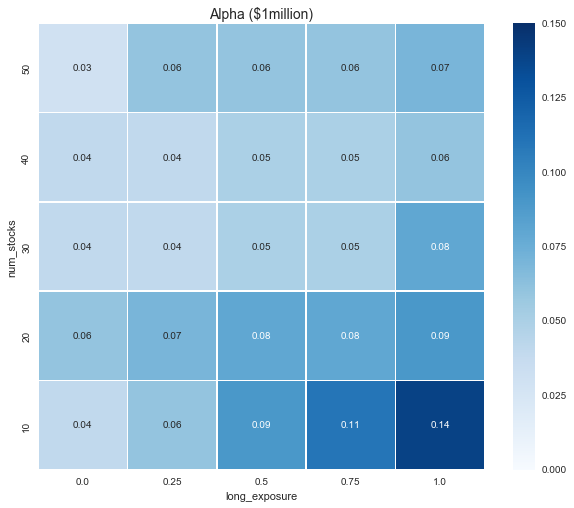

In [41]:
get_heatmap_plain(alpha_1_mil, 'Alpha', '1', 0.15, 0)

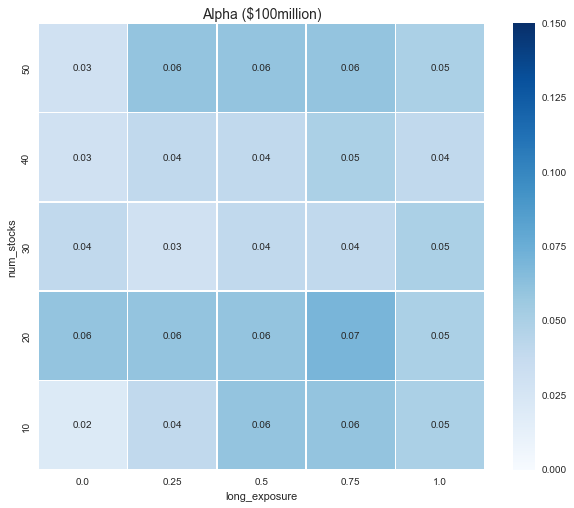

In [42]:
get_heatmap_plain(alpha_100_mil, 'Alpha', '100', 0.15, 0)

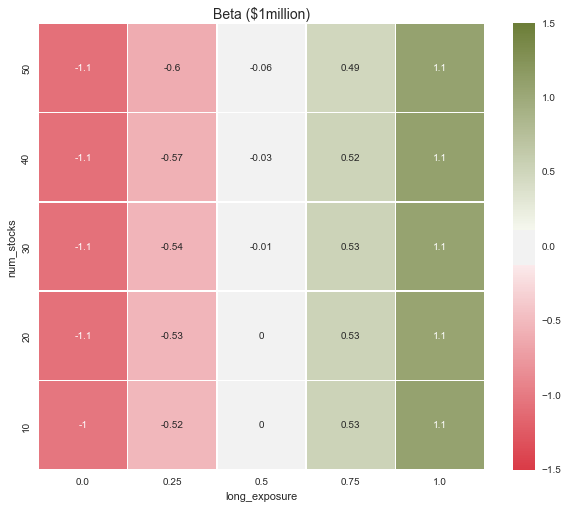

In [43]:
get_heatmap(beta_1_mil, 'Beta', '1', 10, 100, 1.5, -1.5)

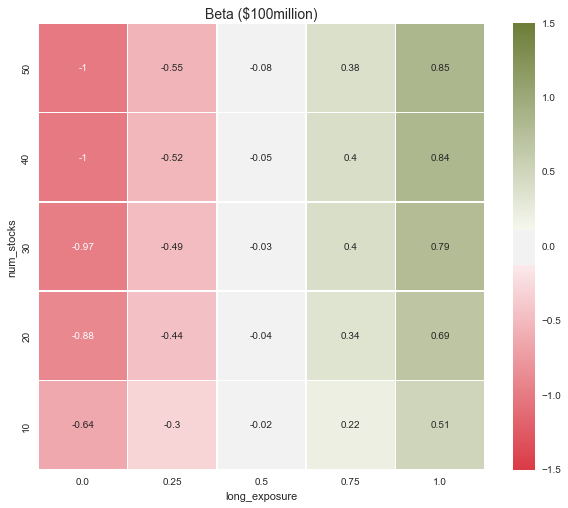

In [44]:
get_heatmap(beta_100_mil, 'Beta', '100', 10, 100, 1.5, -1.5)

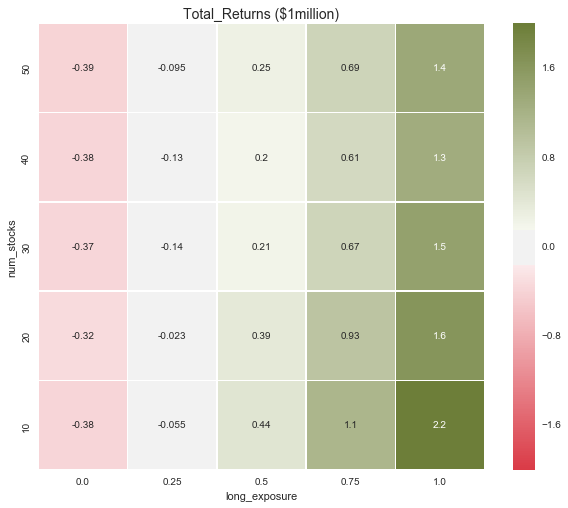

In [45]:
get_heatmap(total_r_1_mil, 'Total_Returns', '1', 10, 100, 2, -2)

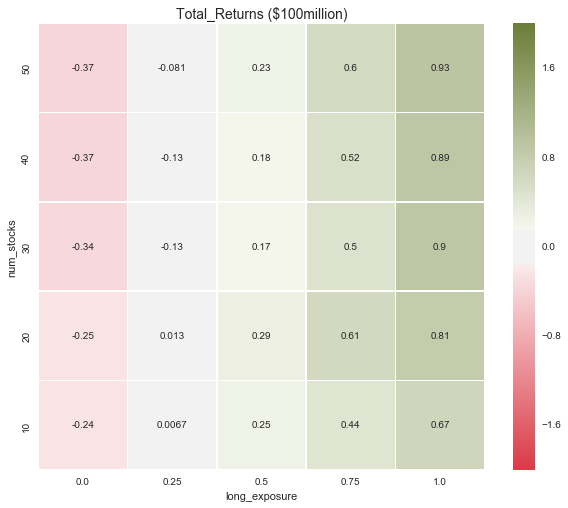

In [46]:
get_heatmap(total_r_100_mil, 'Total_Returns', '100', 10, 100, 2, -2)

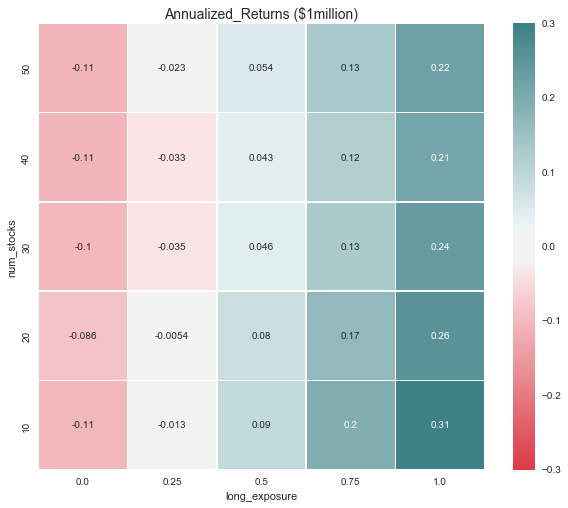

In [47]:
get_heatmap(annualized_1_mil, 'Annualized_Returns', '1', 10, 200, 0.3, -0.3)

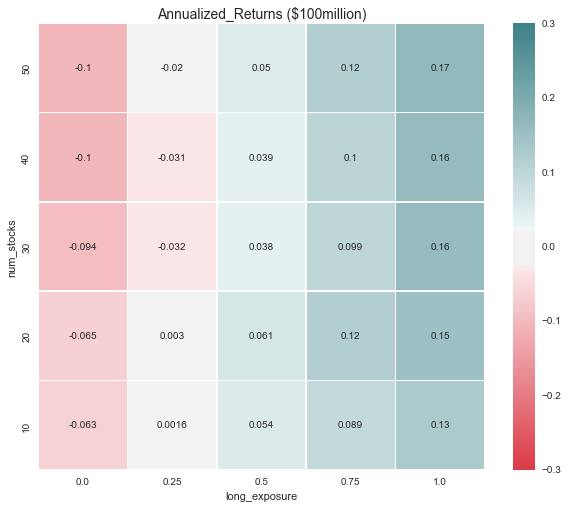

In [48]:
get_heatmap(annualized_100_mil, 'Annualized_Returns', '100', 10, 200, 0.3, -0.3)

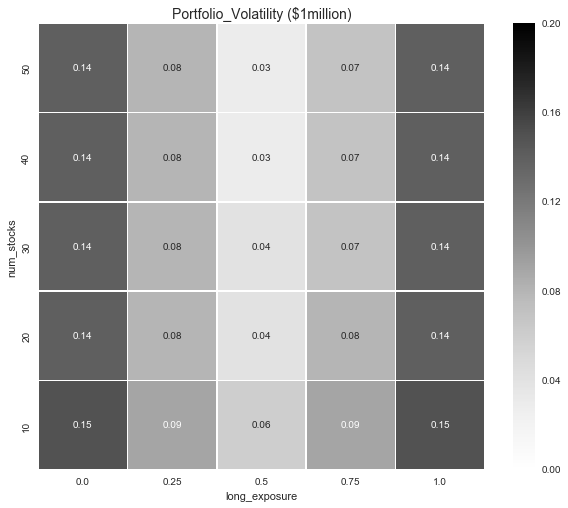

In [49]:
get_heatmap_plain_grey(vol_1_mil, 'Portfolio_Volatility', '1', 0.2, 0)

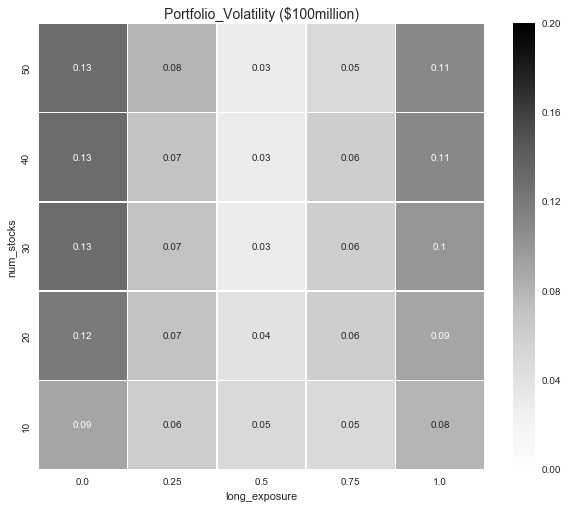

In [50]:
get_heatmap_plain_grey(vol_100_mil, 'Portfolio_Volatility', '100', 0.2, 0)

# Get Three Columns for FF and HFRI graphs

In [51]:
research.head()

,algo_id,algo_name,backtest_id,alpha,beta,sharpe,sortino,total_returns,benchmark_returns,volatility,...,backtest_url,algo_file,data_file,start_date,end_date,capital,num_stocks_to_trade,long_half,short_half,annualized_returns
0,5ab2ad341274a90a283a605c,3_21_vipul_multi_data_3_ctc_100mil_23,5ab2ad471311344338806fc9,0.06,-0.08,1.53,2.31,0.2300,0.711,0.03,...,https://www.quantopian.com/algorithms/5ab2ad34...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,50,0.50,0.50,0.049915
1,5ab2a8181274a96da63a608b,3_21_vipul_multi_data_3_ctc_1mil_21,5ab2a8260ddace414b0dcb9e,0.07,1.08,1.50,2.16,1.3518,0.711,0.14,...,https://www.quantopian.com/algorithms/5ab2a818...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,50,1.00,0.00,0.222893
2,5ab2a3e01274a900153a6262,3_21_vipul_multi_data_3_ctc_1mil_2,5ab2a3f21311344338806e11,0.11,0.53,2.04,3.15,1.1435,0.711,0.09,...,https://www.quantopian.com/algorithms/5ab2a3e0...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,1000000,10,0.75,0.25,0.196496
3,5ab2ad041274a9000f3a62f0,3_21_vipul_multi_data_3_ctc_100mil_22,5ab2ad16fe98ee41037abd7a,0.06,0.38,2.00,3.02,0.5994,0.711,0.05,...,https://www.quantopian.com/algorithms/5ab2ad04...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,50,0.75,0.25,0.116837
4,5ab2a9f4ce20ea07dbd504e1,3_21_vipul_multi_data_3_ctc_100mil_7,5ab2aa0673168242ea8c84db,0.07,0.34,1.99,3.01,0.6118,0.711,0.06,...,https://www.quantopian.com/algorithms/5ab2a9f4...,3_21_run_vipul_multi_data_3_sp500_CTC.py,https://dl.dropboxusercontent.com/s/i2owo338rz...,8/1/13,11/30/17,100000000,20,0.75,0.25,0.118869


In [58]:
cols_to_drop = list(set(list(research.columns)) - set(['backtest_id', 'long_half', 'num_stocks_to_trade']))

In [62]:
research.drop(cols_to_drop, axis=1, inplace=True)

In [69]:
# Rearrange the order of the columns to match the column order in the quantopian notebooks when processing the dataframes 
# of these three columns:
research = research[['backtest_id', 'long_half', 'num_stocks_to_trade']]

In [71]:
research.head()

,backtest_id,long_half,num_stocks_to_trade
0,5ab2ad471311344338806fc9,0.50,50
1,5ab2a8260ddace414b0dcb9e,1.00,50
2,5ab2a3f21311344338806e11,0.75,10
3,5ab2ad16fe98ee41037abd7a,0.75,50
4,5ab2aa0673168242ea8c84db,0.75,20


In [72]:
research.to_csv('3_21_vipul_multi_data_3_sp500_ctc_daily_results_three_cols.csv', index = False)

# Open this saved three-col research csv with Sublime and copy & paste to Q nb